<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#ROC/AUC:" data-toc-modified-id="ROC/AUC:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>ROC/AUC:</a></span><ul class="toc-item"><li><span><a href="#SMOTE:" data-toc-modified-id="SMOTE:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>SMOTE:</a></span></li></ul></li><li><span><a href="#Pruning" data-toc-modified-id="Pruning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pruning</a></span></li><li><span><a href="#Decision-Tree:" data-toc-modified-id="Decision-Tree:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Decision Tree:</a></span></li></ul></div>

- Who is controlling 4 central squares: d4, d5, e4, e5
- Who captured the first piece
- Which player castles sooner
- Does player castle (yes, no)
- Who moves all of their pieces off of the back row the quickest

    # tutor.peterl@gmail.com

Logistic Regression
Matrix Feature adjustments (need name)
Feature importance
Subspace sampling
Ensemble methods
Random forest method
GridsearchCV (combinatorial, exhaustive)

Parameter Tuning

Grid Searching Cross val score for random forest classifier
AdaBoost - tuning gradient boosted trees
Gradient Boosting
Weak vs Strong learners
XGBoost - extreme gradient boosting

In [64]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#import sqlalchemy
#from sqlalchemy import create_engine
#from sqlalchemy.orm import Session, sessionmaker
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.formula.api import ols


from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression, 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier 
from imblearn.over_sampling import SMOTE, ADASYN

In [2]:
df = pd.read_csv('games.csv')
df.columns

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')

In [3]:
print(df.moves[:1])

0    d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...
Name: moves, dtype: object


In [4]:
df.head(2)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4


In [5]:
df.winner.value_counts()

white    10001
black     9107
draw       950
Name: winner, dtype: int64

In [6]:
df['rating_difference'] = (df['white_rating'] - df['black_rating'])

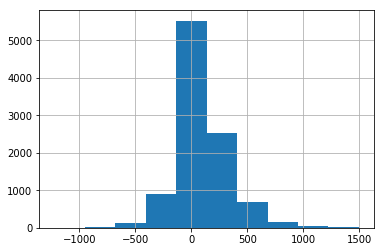

In [7]:
df.rating_difference[df.winner == 'white'].hist()

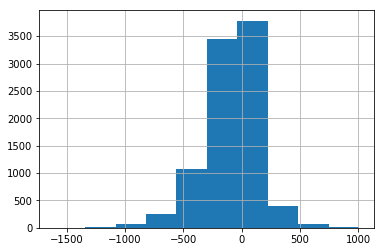

In [8]:
df.rating_difference[df.winner == 'black'].hist()

In [9]:
df.moves[0].split()

['d4',
 'd5',
 'c4',
 'c6',
 'cxd5',
 'e6',
 'dxe6',
 'fxe6',
 'Nf3',
 'Bb4+',
 'Nc3',
 'Ba5',
 'Bf4']

In [10]:
df.iloc[2]

id                                                            mIICvQHh
rated                                                             True
created_at                                                 1.50413e+12
last_move_at                                               1.50413e+12
turns                                                               61
victory_status                                                    mate
winner                                                           white
increment_code                                                    5+10
white_id                                                        ischia
white_rating                                                      1496
black_id                                                          a-00
black_rating                                                      1500
moves                e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...
opening_eco                                                        C20
openin

In [11]:
df.moves.value_counts()

e4 e5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         27
e4 d5                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [151]:
def first_capture(moves):
    for index, move in enumerate(moves.split()):
        if 'x' in move:
            if index%2==0:
                return 'white'
            else:
                return 'black'
    return None


def count_captures(moves):
    white_captures = 0
    black_captures = 0
    for index, move in enumerate(moves.split()):
        if 'x' in move:
            if index%2 == 0:
                white_captures += 1
            else:
                black_captures += 1
    return [white_captures, black_captures]


def count_n_captures(moves, n=3):
    white_captures = 0
    black_captures = 0
    for index, move in enumerate(moves.split()):
        if 'x' in move:
            if index%2 == 0:
                white_captures += 1
            else:
                black_captures += 1
        if white_captures == n or black_captures == n:
            return 'white' if white_captures == n else 'black'
        
def first_castle(moves):
    for index, move in enumerate(moves.split()):
        if move in ('O-O', 'O-O-O'):
            color = 'white' if index%2==0 else 'black'
            return '{}_{}'.format(color, move.replace("-", "_"))
    return None 


def make_features(df, n):
    df['count_captures'] = df['moves'].apply(count_captures)
    n_captures = [count_n_captures(move, n) for move in df['moves']]
    df[f'count_{n}_captures'] = n_captures
    df['first_castle'] = df['moves'].apply(first_castle)
    return df

In [96]:
raf_df = pd.read_csv("games.csv")
raf_df.head(1)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5


In [152]:
raf_df = make_features(raf_df, n=5)
raf_df.head(3)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,count_captures,count_n_captures,first_castle,count_5_captures
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,"[2, 1]",None,None,None
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,"[2, 3]",black,None,None
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,"[14, 3]",white,None,white


'd4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5 Bf4'

In [130]:
moves0 = raf_df.moves[0]
first_cap(moves0), count_captures(moves0), count_n_captures(moves0, 2)

('white', (2, 1), 'white')

In [15]:
df.moves[6]

'd4 d5 e4 dxe4 Nc3 Nf6 f3 exf3 Nxf3 Nc6 Bb5 a6 Bd3 Bg4 O-O Nxd4 Be2 Nxe2+ Qxe2 Bxf3 Qxf3 Qd4+ Be3 Qg4 Qxb7 Rd8 Qc6+ Nd7 Nd5 e6 Nxc7+ Ke7 Bd2'

In [16]:
first_castle(df.moves[4])

'black'

In [17]:
# Splitting time into minutes and increment_seconds:
df['minutes'] = df['increment_code'].apply(lambda x: x.split('+')[0])

df['increment_secs'] = df['increment_code'].apply(lambda x: x.split('+')[1])
df.head(3)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,rating_difference,minutes,increment_secs
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,309,15,2
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,61,5,10
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,-4,5,10


In [18]:
df.victory_status.value_counts()

resign       11147
mate          6325
outoftime     1680
draw           906
Name: victory_status, dtype: int64

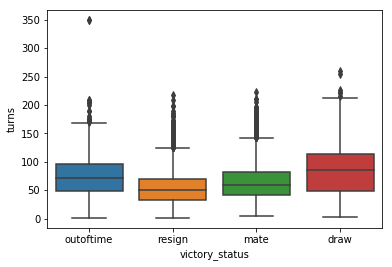

In [19]:
g = sns.boxplot(x = 'victory_status', y = 'turns', data = df)

In [20]:
#df.winner.replace({'black': 0, 'white': 1}, inplace=True)
df.rated.replace({False: 0, True: 1}, inplace=True)
print(df.winner.value_counts())
print('')
print(df.rated.value_counts())

white    10001
black     9107
draw       950
Name: winner, dtype: int64

1    16155
0     3903
Name: rated, dtype: int64


In [21]:
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,rating_difference,minutes,increment_secs
0,TZJHLljE,0,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,309,15,2
1,l1NXvwaE,1,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,61,5,10
2,mIICvQHh,1,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,-4,5,10
3,kWKvrqYL,1,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,-15,20,0
4,9tXo1AUZ,1,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,54,30,3


In [22]:
# Drop unnecessary features from dataframe:
df.drop(['id', 'created_at', 'last_move_at', 'white_id', 'black_id'], axis=1, inplace=True)
#df_target = df.winner
#df.drop(['winner'], axis=1, inplace=True)

In [23]:
df = df[df['winner'] != 'draw']
df.winner.unique()

array(['white', 'black'], dtype=object)

In [82]:
y.winner.unique()

array(['white', 'black'], dtype=object)

In [25]:
# Winner vs. First move:

df[['first_move', 'winner', 'victory_status']].groupby(['first_move', 'winner']).count()#.plot(kind='barh')

#sns.barplot()

victory_status
first_move winner                
Na3        black                3
           white                1
Nc3        black               55
           white               42
Nf3        black              292
           white              373
Nh3        black                6
           white                9
a3         black                9
           white               17
a4         black               18
           white                9
b3         black               83
           white               82
b4         black               36
           white               48
c3         black               25
           white               31
c4         black              305
           white              383
d3         black               79
           white               50
d4         black             2043
           white             2258
e3         black              255
           white              142
e4         black             5651
           white             6371
f3         black               13
           white                8
f4         black               82
           white               68
g3         black               95
           white               85
g4         black               25
           white               11
h3         black                7
           white                7
h4         black               25
           white                6

In [26]:
# Creating Dummies and Dropping Columns:
first_move_dummies = pd.get_dummies(df.first_move, prefix = 'first')
df.drop(['first_move'], axis=1, inplace=True)
df.drop(['moves'], axis=1, inplace=True)
df = pd.concat([df, first_move_dummies], axis=1)

# Removing games with no pieces captured and creating dummies
df = df[df.first_capture != 'no']
first_capture_dummies = pd.get_dummies(df.first_capture, prefix = 'first_cap')
df = pd.concat([df, first_capture_dummies], axis=1)

first_5_capture_dummies = pd.get_dummies(df.first_5_captures, prefix = 'first_5_cap')
df = pd.concat([df, first_5_capture_dummies], axis=1)

first_castle_dummies = pd.get_dummies(df.first_castle, prefix = 'first_castle')
df.drop(['first_castle'], axis=1, inplace=True)
df = pd.concat([df, first_castle_dummies], axis=1)

victory_status_dummies = pd.get_dummies(df.victory_status, prefix='victory')
df = pd.concat([df, victory_status_dummies], axis=1)
df.drop(['victory_status'], axis=1, inplace=True)

opening_eco_dummies = pd.get_dummies(df.opening_eco, prefix='opening_eco')
df.drop(['opening_eco'], axis=1, inplace=True)
df = pd.concat([df, opening_eco_dummies], axis=1)

df.drop(['opening_name', 'increment_code', ], axis=1, inplace=True)

df.head(10)

,rated,turns,winner,white_rating,black_rating,opening_ply,rating_difference,minutes,increment_secs,first_capture,...,opening_eco_E81,opening_eco_E87,opening_eco_E88,opening_eco_E90,opening_eco_E91,opening_eco_E92,opening_eco_E94,opening_eco_E95,opening_eco_E97,opening_eco_E98
0,0,13,white,1500,1191,5,309,15,2,1,...,0,0,0,0,0,0,0,0,0,0
1,1,16,black,1322,1261,4,61,5,10,1,...,0,0,0,0,0,0,0,0,0,0
2,1,61,white,1496,1500,3,-4,5,10,1,...,0,0,0,0,0,0,0,0,0,0
3,1,61,white,1439,1454,3,-15,20,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,95,white,1523,1469,5,54,30,3,1,...,0,0,0,0,0,0,0,0,0,0
6,1,33,white,1520,1423,10,97,10,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,66,black,1439,1392,6,47,15,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,119,white,1381,1209,4,172,10,0,1,...,0,0,0,0,0,0,0,0,0,0
10,0,39,white,1381,1272,1,109,20,60,1,...,0,0,0,0,0,0,0,0,0,0
11,0,38,black,1381,1867,9,-486,20,60,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
#for col in df.columns:
#    print(df[col].value_counts())

In [28]:
PCA_code = """
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
PCs = pca.fit_transform(first_move_dummies)

PCs_df = pd.DataFrame(data = PCs, columns = ['PC1', 'PC2'])
PCs_df = PCs_df.assign(winner = df['winner'])

sns.scatterplot(x = 'PC1', y = 'PC2',
                hue = 'winner',
                data = PCs_df,
                alpha = 0.5)

PCs_df.head()
"""

In [29]:
# Selecting 8 most common first moves:
moves_to_use = first_move_dummies.sum().sort_values(ascending=False).head(8).index.tolist()
moves_to_use

['first_e4',
 'first_d4',
 'first_c4',
 'first_Nf3',
 'first_e3',
 'first_g3',
 'first_b3',
 'first_f4']

In [30]:
# Normalizing Rating Difference:
col = 'rating_difference'
df['rating_difference_norm'] = (df[col] - min(df[col])) / (max(df[col]) - min(df[col]))

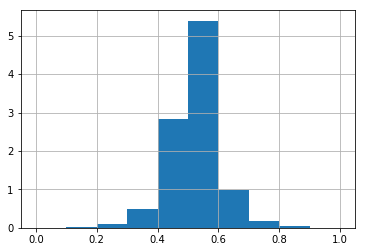

In [31]:
# Reviewing Distribution:
df.rating_difference_norm.hist(density=True)

In [32]:
df.describe()

,rated,turns,white_rating,black_rating,opening_ply,rating_difference,first_Na3,first_Nc3,first_Nf3,first_Nh3,...,opening_eco_E87,opening_eco_E88,opening_eco_E90,opening_eco_E91,opening_eco_E92,opening_eco_E94,opening_eco_E95,opening_eco_E97,opening_eco_E98,rating_difference_norm
count,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,...,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000,18632.000000
mean,0.810434,60.572832,1596.694343,1589.810004,4.863729,6.884339,0.000161,0.004938,0.035155,0.000698,...,0.000161,0.000161,0.001556,0.000322,0.000107,0.000322,0.000054,0.000107,0.000107,0.519293
std,0.391968,31.513887,287.190064,287.975841,2.781903,246.502101,0.012688,0.070097,0.184175,0.026406,...,0.012688,0.012688,0.039422,0.017943,0.010360,0.017943,0.007326,0.010360,0.010360,0.079414
min,0.000000,3.000000,784.000000,789.000000,1.000000,-1605.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,38.000000,1400.000000,1393.000000,3.000000,-107.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.482603
50%,1.000000,55.000000,1567.000000,1562.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.518041
75%,1.000000,77.000000,1790.000000,1784.000000,6.000000,121.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.556057
max,1.000000,349.000000,2700.000000,2621.000000,28.000000,1499.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
# Feature Engineering - How many of first 3 moves control/attack the center 'e4, e5, d4, d5'
# Possible moves:
#    - White: d3, d4, e3, e4, Nf3, Nc3, 
#    - Black:

In [34]:
# Feature Engineering - Queen Side vs. King Side Castling:
# Implement this!!!

In [35]:
# Choose X, y:
#X = df[['first_cap_black', 'first_5_cap_black', 'first_5_cap_white', 'rating_difference_norm', 'first_castle_white', 'first_castle_no', 'first_castle_black', '']]
#X = df.winner.drop(inplace=False)
#y = df['winner']

In [36]:
#df.first_castle_black.unique()

In [37]:
#df.first_5_cap_tie.unique()

In [38]:
# This code would normalize columns: Should I run this before instead of just normalizing
# rating difference above?

#for col in df.columns:
#    df[col] = (df[col] - min(df[col])) / (max(df[col]) - min(df[col]))

In [39]:
# INSTEAD: I would prefer to make target first column and just reference it by slicing
# instead of creating new dataframe. Is that better?

y = df[['winner']]
X = df.drop(['winner'], axis=1)

X.columns

Index(['rated', 'turns', 'white_rating', 'black_rating', 'opening_ply',
       'rating_difference', 'minutes', 'increment_secs', 'first_capture',
       'first_5_captures',
       ...
       'opening_eco_E87', 'opening_eco_E88', 'opening_eco_E90',
       'opening_eco_E91', 'opening_eco_E92', 'opening_eco_E94',
       'opening_eco_E95', 'opening_eco_E97', 'opening_eco_E98',
       'rating_difference_norm'],
      dtype='object', length=400)

In [40]:
y.winner.value_counts()

white    9740
black    8892
Name: winner, dtype: int64

In [41]:
print(X.shape)
print(y.shape)
y.head( 3 )

(18632, 400)
(18632, 1)


,winner
0,white
1,black
2,white


In [42]:
y.head()

,winner
0,white
1,black
2,white
3,white
4,white


In [77]:
display(X.head())
display(y.head())

,rated,turns,white_rating,black_rating,opening_ply,rating_difference,minutes,increment_secs,first_capture,first_5_captures,...,opening_eco_E87,opening_eco_E88,opening_eco_E90,opening_eco_E91,opening_eco_E92,opening_eco_E94,opening_eco_E95,opening_eco_E97,opening_eco_E98,rating_difference_norm
0,0,13,1500,1191,5,309,15,2,1,1,...,0,0,0,0,0,0,0,0,0,0.616624
1,1,16,1322,1261,4,61,5,10,1,0,...,0,0,0,0,0,0,0,0,0,0.536727
2,1,61,1496,1500,3,-4,5,10,1,1,...,0,0,0,0,0,0,0,0,0,0.515786
3,1,61,1439,1454,3,-15,20,0,0,1,...,0,0,0,0,0,0,0,0,0,0.512242
4,1,95,1523,1469,5,54,30,3,1,1,...,0,0,0,0,0,0,0,0,0,0.534472


,winner
0,white
1,black
2,white
3,white
4,white


In [78]:
#Normalize the Data
#for col in df.columns:
#    df[col] = (df[col]-min(df[col]))/ (max(df[col]) - min(df[col]))

# Split the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20)

In [155]:
# Fit a model
logreg = LogisticRegression(fit_intercept = False, C = 1e12, verbose=1) #Starter code
logreg.fit(X_train, y_train)
 #Preview model params
display(logreg)
# Predict
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear]

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=1, warm_start=False)

In [156]:
logreg.score(X_test, y_test), logreg.score(X_train, y_train)

(0.7002951435470888, 0.712110030191211)

In [164]:
train_residuals =  np.equal(y_train.values.reshape(1, -1), y_hat_train.reshape(1, -1))[0]
train_residuals

array([ True,  True, False, ...,  True,  True,  True])

In [93]:
X.shape

(18632, 400)

In [95]:
for col in df.columns:
    print(col)

rated
turns
winner
white_rating
black_rating
opening_ply
rating_difference
minutes
increment_secs
first_capture
first_5_captures
first_Na3
first_Nc3
first_Nf3
first_Nh3
first_a3
first_a4
first_b3
first_b4
first_c3
first_c4
first_d3
first_d4
first_e3
first_e4
first_f3
first_f4
first_g3
first_g4
first_h3
first_h4
first_cap_0
first_cap_1
first_5_cap_0
first_5_cap_1
first_castle_0
first_castle_1
first_castle_no
victory_mate
victory_outoftime
victory_resign
opening_eco_A00
opening_eco_A01
opening_eco_A02
opening_eco_A03
opening_eco_A04
opening_eco_A05
opening_eco_A06
opening_eco_A07
opening_eco_A08
opening_eco_A09
opening_eco_A10
opening_eco_A11
opening_eco_A12
opening_eco_A13
opening_eco_A14
opening_eco_A15
opening_eco_A16
opening_eco_A17
opening_eco_A18
opening_eco_A20
opening_eco_A21
opening_eco_A22
opening_eco_A23
opening_eco_A24
opening_eco_A25
opening_eco_A27
opening_eco_A28
opening_eco_A29
opening_eco_A30
opening_eco_A31
opening_eco_A33
opening_eco_A34
opening_eco_A35
opening_eco_A36

In [91]:
for col1 in X.columns:
    for col2 in X.columns:
        if col2 == col1:
            pass
        else:
            corr = np.corrcoef(X[col1], X[col2])[0][1]
            if corr > 0.20:
                print(col1, col2, corr)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [45]:
'''
def plot_confusion_matrix(cm, classes,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    #Print the confusion matrix
    print(cm)
    
    #Create the basic matrix.
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    #Add title and Axis Labels
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
'''

'\ndef plot_confusion_matrix(cm, classes,\n                          title=\'Confusion Matrix\',\n                          cmap=plt.cm.Blues):\n    #Print the confusion matrix\n    print(cm)\n    \n    #Create the basic matrix.\n    plt.imshow(cm, interpolation=\'nearest\', cmap=cmap)\n    \n    #Add title and Axis Labels\n    plt.title(title)\n    plt.colorbar()\n    tick_marks = np.arange(len(classes))\n    plt.xticks(tick_marks, classes, rotation=45)\n    plt.yticks(tick_marks, classes)\n\n    fmt = \'.2f\' if normalize else \'d\'\n    thresh = cm.max() / 2.\n    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):\n        plt.text(j, i, format(cm[i, j], fmt),\n                 horizontalalignment="center",\n                 color="white" if cm[i, j] > thresh else "black")\n\n    plt.tight_layout()\n    plt.ylabel(\'True Label\')\n    plt.xlabel(\'Predicted Label\')\n'

In [46]:
# Creating function to plot confusion matrices:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    # Check if Normalization Option is Set to True. 
    # If so, normalize the raw confusion matrix before visualizing
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without Normalization')
        
    # Print CNF Matrix
    print(cm)
    
    # Create the Matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    # Add Title, Axis Labels:
    # . classes = class_names
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add cell labels:
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

In [47]:
# DF object has no att val_counts

#print(y_train.value_counts())
#print(y_test.value_counts())

In [53]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

In [49]:
# Train test split:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# Fit a model:
#logreg = LogisticRegression(fit_intercept = False, C = 1e12) #Starter code
#model_log = logreg.fit(X_train, y_train)
#print(model_log) #Preview model params

# Predict:
#y_hat_test = logreg.predict(X_test)

In [54]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_hat_test, y_test)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[1215  575]
 [ 551 1386]]


{'winner'}
Normalized Confusion Matrix
[[0.67877095 0.32122905]
 [0.28446051 0.71553949]]


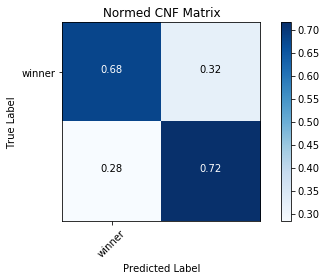

In [55]:
# Visualizing Normalized CNF Matrix:
class_names = set( y )
print( class_names )
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=True, title='Normed CNF Matrix')
plt.show()

In [153]:
# Initial Evaluation:
residuals = y_train - y_hat_train
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

ValueError: Unable to coerce to Series, length must be 1: given 14905

In [ ]:
# Fit a model
logreg = LogisticRegression(fit_intercept = False, C = 1e12, solver='lbfgs') #Starter code

model_log = logreg.fit(X_train, y_train)
model_log #Preview model params

## ROC/AUC:

/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC: 0.7676832379607075


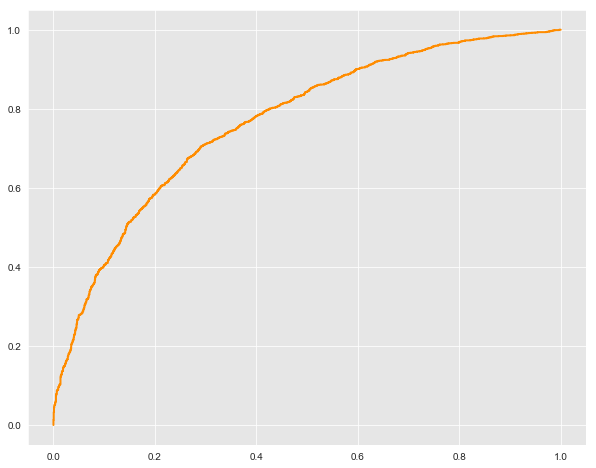

In [172]:
#AUC/ROC Not yet working:

#Initial Model:
logreg = LogisticRegression(fit_intercept = False)

# Probability scores for test set:
y_score = logreg.fit(X_train, y_train).decision_function(X_test)

# False Positive Rate (fpr) and True Positive Rate (tpr):
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score, pos_label='white')

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# Print AUC, Plot ROC Curve:
print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.show()
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.yticks([i/20.0 for i in range(21)])
# plt.xticks([i/20.0 for i in range(21)])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic (ROC) Curve')
# plt.legend(loc="best")
# plt.show()

In [ ]:
# Fit model:
#logreg = LogisticRegression(fit_intercept=False, C=1e12)
#model_log = logreg.fit(X_train, y_train)
#print(model_log) #preview params

# Predict:
#y_hat_test = logreg.predict(X_test)

Next we will employ various techniques in order to tune our initial model:

In [ ]:
C_param_range = [0.001,0.01,0.1,1,10,100]
names = [0.001,0.01,0.1,1,10,100]
colors = sns.color_palette('Set2')

plt.figure(figsize=(10,8))

for n, c in enumerate(C_param_range):
    # Fit a model:
    logreg = LogisticRegression(fit_intercept = False, C = c) #Starter code
    model_log = logreg.fit(X_train, y_train)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='teal', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()

Necessary?


### SMOTE:

Next, let's use the SMOTE class from imblearn to improve model performance on the minority class.

In [ ]:
print(y_train.value_counts()) #Previous original class distribution
X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train, y_train) 
print(pd.Series(y_train_resampled).value_counts()) #Preview synthetic sample class distribution

In [ ]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
colors = sns.color_palette("Set2", n_colors=len(names))

plt.figure(figsize=(10,8))

for n, c in enumerate(C_param_range):
    #Fit a model
    logreg = LogisticRegression(fit_intercept = False, C = c) #Starter code
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) #Preview model params

    #Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Regularization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y.winner.value_counts()

In [ ]:
y.head(10)

In [ ]:
# Calculate the probability scores of each of the datapoints:
#y_score = model_log.decision_function(X_test)

#fpr, tpr, thresholds = roc_curve(y_test, y_score)

#y_train_score = model_log.decision_function(X_train)
#train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

In [58]:
# Create first model:
lr = LogisticRegression(fit_intercept=False, C=1e12, solver='lbfgs')
rf = RandomForestClassifier(n_estimators = 100)
nb = MultinomialNB()

models = {
    'Logistic Regression' : lr,
    'Random Forest'       : rf,
    'Mult. Naive Bayes'   : nb
}

for name, model in models.items():
    model.fit(X, y)
    print(name, end = '')
    # Calculating Scores:
    scores = cross_val_score(model, X, y, cv=10)
    print(' - mean score: ', np.mean(scores))
    #print(scores)

       winner
count   18632
unique      2
top     white
freq     9740


/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic Regression

/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iteratio

 - mean score:  0.7023936311132306


/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Random Forest

/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-pack

 - mean score:  0.7218756839192866


/Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Input X must be non-negative

## Pruning

In [60]:
# Feature Importance
features = pd.DataFrame(columns = ['feature', 'importance'])
features['feature']    = X.columns
features['importance'] = rf.feature_importances_
features.sort_values('importance', ascending=False)

,feature,importance
399,rating_difference_norm,1.136026e-01
5,rating_difference,1.120121e-01
1,turns,8.403196e-02
3,black_rating,8.331504e-02
2,white_rating,8.001731e-02
4,opening_ply,4.202205e-02
6,minutes,3.925349e-02
32,first_5_cap_0,3.841141e-02
33,first_5_cap_1,3.615294e-02
7,increment_secs,3.483927e-02


In [ ]:
df.columns

In [ ]:
df.head()

In [ ]:
train_test_split(df)
X_train, X_test, y_train, y_test = train_test_split(df, df_features, test_size=.2)

In [ ]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='lbfgs')

model_log = logreg.fit(X_train, y_train)
model_log

## Decision Tree:

In [59]:
from sklearn.tree import DecisionTreeClassifier

In [61]:
# Train Decision Tree Classifier:
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [62]:
# Make Predictions for test data:
y_pred = classifier.predict(X_test)

In [65]:
# Calculate Accuracy , AUC and Confusion matrix 
acc = accuracy_score(y_test,y_pred) * 100
print("Accuracy is :{0}".format(acc))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("\nAUC is :{0}".format(round(roc_auc,2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy is :70.86128253286826


ValueError: Data is not binary and pos_label is not specified

In [66]:
# Train a DT classifier using entropy:
classifier2 = DecisionTreeClassifier(random_state=10, criterion='entropy')  
classifier2.fit(X_train, y_train)  

# Make predictions for test data
y_pred = classifier2.predict(X_test) 

# Calculate Accuracy 
acc = accuracy_score(y_test,y_pred) * 100
print("Accuracy is :{0}".format(acc))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("\nAUC is :{0}".format(round(roc_auc,2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

# Visualize the tree trained from complete dataset (optional)
dot_data = StringIO()
export_graphviz(classifier2, out_file=dot_data, filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Accuracy is :70.59297021733298


ValueError: Data is not binary and pos_label is not specified

In [67]:
fpr, tpr, thresholds = roc_curve(y_test, y_hat_test)

sns.set_style('whitegrid', {'axes.facecolor': '.9'})

print(f'AUC: {auc(fpr, tpr)}')
plt.figure(figsize=(8,6.5))
lw=2

plt.plot(fpr, tpr, color='orange', lw=lw, label='ROC Curve')
plt.plot([0,1], [0,1], color='cyan', lw=lw, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

ValueError: Data is not binary and pos_label is not specified

In [69]:
print(type(y_test))
print(type(y_pred))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [72]:
y_test.head()

,winner
9888,white
13819,white
972,black
8368,black
15382,white


In [73]:
y_pred.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [ ]:
'''
X_train, X_test, y_train, y_test = train_test_split(df_feature_dums, df_target, test_size=0.2, random_state=42)

# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', LogisticRegression(random_state=42))])

pipe_svm = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', svm.SVC(random_state=42))])
        
pipe_dt = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', tree.DecisionTreeClassifier(random_state=42))])

# List of pipelines for ease of iteration
pipelines = [pipe_lr, pipe_svm, pipe_dt]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Support Vector Machine', 2: 'Decision Tree'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

# Compare accuracies
for idx, val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' % (pipe_dict[idx], val.score(X_test, y_test)))

# Identify the most accurate model on test data
best_acc = 0.0
best_clf = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.score(X_test, y_test) > best_acc:
        best_acc = val.score(X_test, y_test)
        best_pipe = val
        best_clf = idx
print('Classifier with best accuracy: %s' % pipe_dict[best_clf])
'''

In [ ]:
'''
# Visualizing CNF Matrix:
plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) #Create the basic matrix.

#Add title and Axis Labels
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

#Add appropriate Axis Scales
class_names = set(y) #Get class labels to add to matrix
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

#Add Labels to Each Cell
thresh = cnf_matrix.max() / 2. #Used for text coloring below
#Here we iterate through the confusion matrix and append labels to our visualization.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

#Add a Side Bar Legend Showing Colors
plt.colorbar()
'''